In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import itertools

In [2]:
class TRPO(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(TRPO, self).__init__()
        self.t = 0
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.fc_1 = nn.Linear(num_inputs, 128)
        self.fc_2 = nn.Linear(128, 64)
        self.fc_3 = nn.Linear(64, num_outputs)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform(m.weight)

    def forward(self, input):
        x = torch.relu(self.fc_1(input))
        x = torch.relu(self.fc_2(x))
        policy = F.softmax(self.fc_3(x),dim=-1)

        return Categorical(policy)


In [3]:
def gen_param_array(l16_array):
    full = []
    for row in range(len(l16_array)):
        x = l16_array[row]
        arr_params = []
        
        for col in range(len(x)):
            list_params = list(params.values())[col]
            value = list_params[x[col]]
            arr_params.append(value)
        print(arr_params)
        full.append(arr_params)
    return full

In [4]:
def IQR(arr):
    # First quartile (Q1)
    Q1 = np.percentile(arr, 25, interpolation = 'midpoint')

    # Third quartile (Q3)
    Q3 = np.percentile(arr, 75, interpolation = 'midpoint')

    # Interquaritle range (IQR)
    IQR = Q3 - Q1
    return IQR

# Detrending

In [5]:
def differencing(dataset,interval):
    diff = []
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)

Detrended Trial 0 IQR: 205.38758503401368
Detrended Trial 1 IQR: 212.3000000000011
Detrended Trial 2 IQR: 188.39999999999964
Detrended Trial 3 IQR: 218.5
Detrended Trial 4 IQR: 207.3000000000011
Detrended Trial 5 IQR: 214.99999999999818
Detrended Trial 6 IQR: 214.00000000000182
Detrended Trial 7 IQR: 197.6999999999989
Detrended Trial 8 IQR: 170.4999999999991
Detrended Trial 9 IQR: 194.0
Detrended Trial 10 IQR: 221.09999999999854
Detrended Trial 11 IQR: 217.20000000000255
Detrended Trial 12 IQR: 203.9999999999991
Detrended Trial 13 IQR: 241.19861239593047
Detrended Trial 14 IQR: 236.8000000000011
Detrended Trial 15 IQR: 229.6999999999989


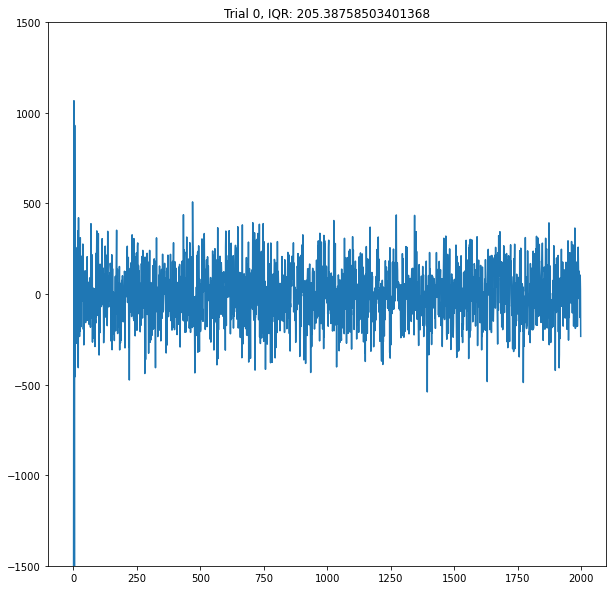

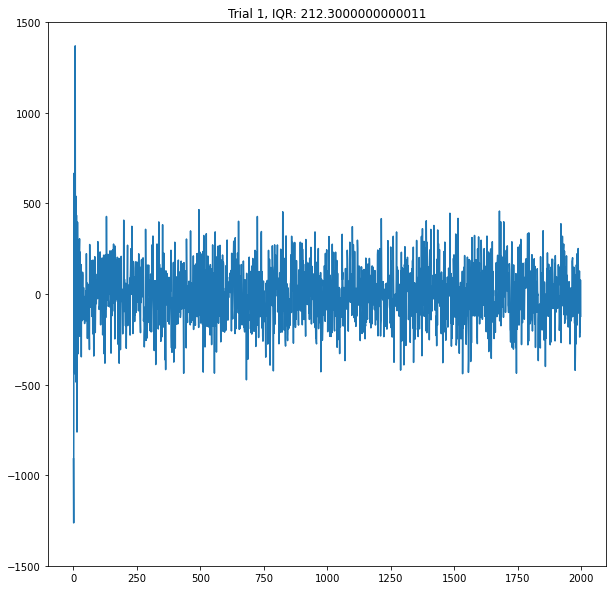

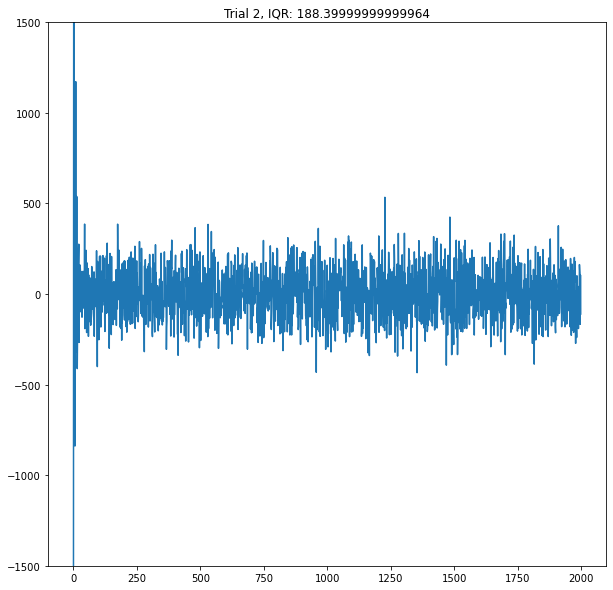

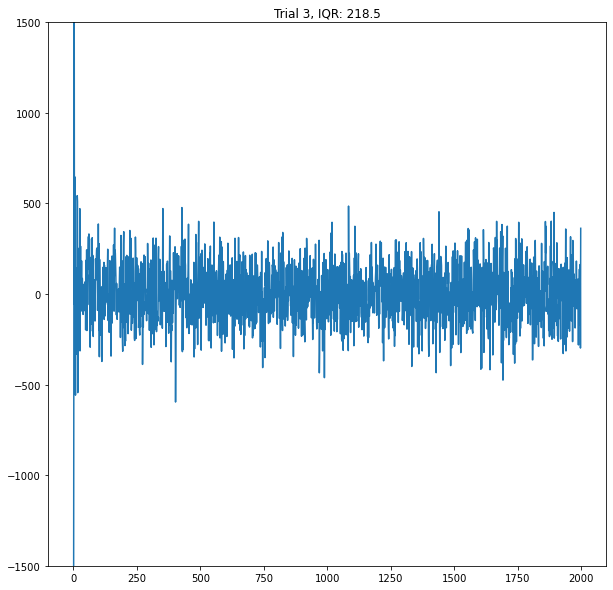

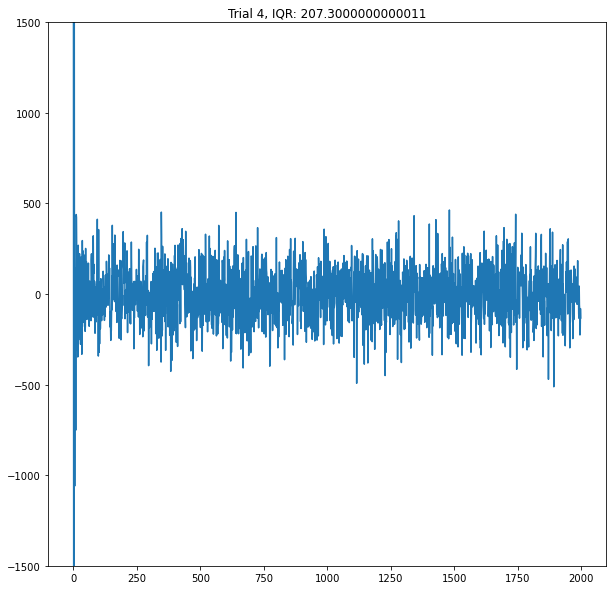

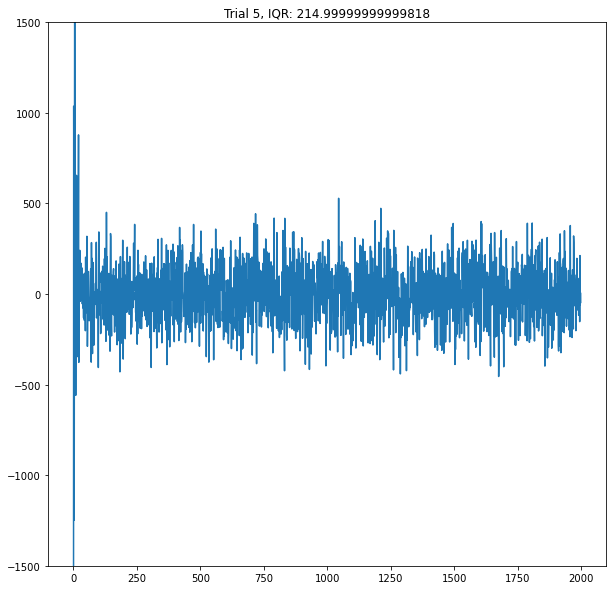

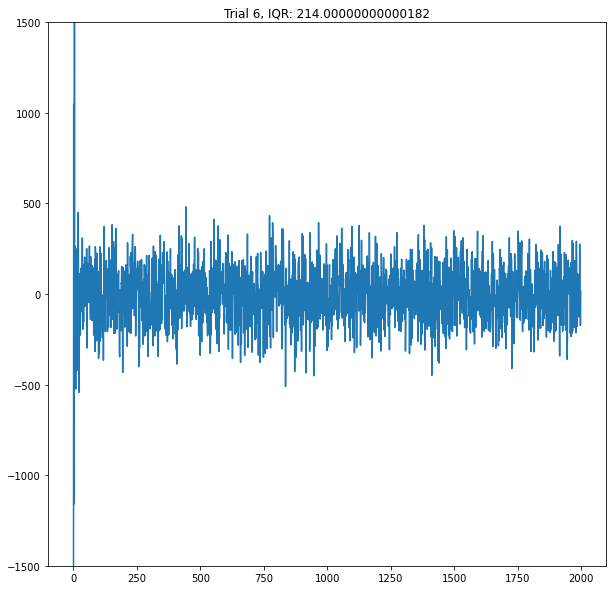

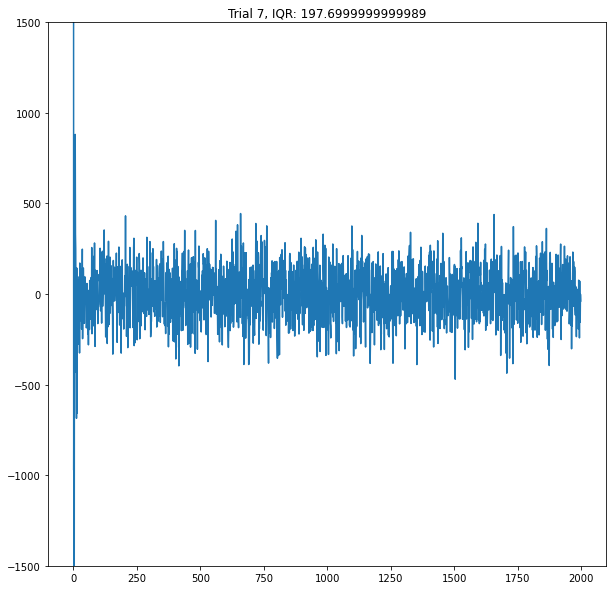

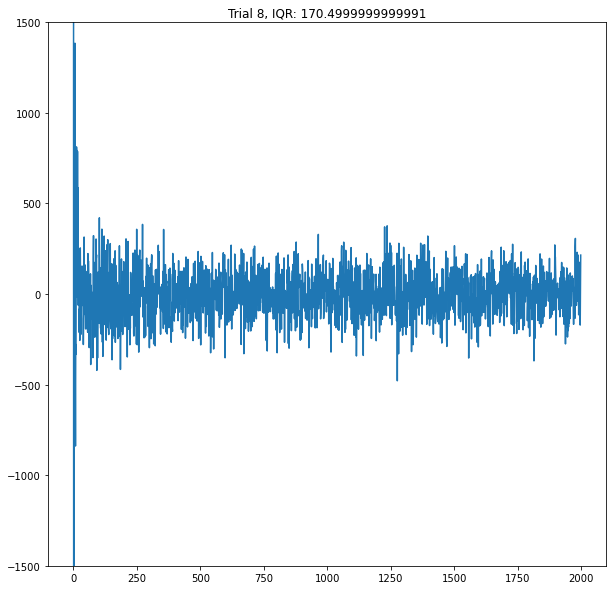

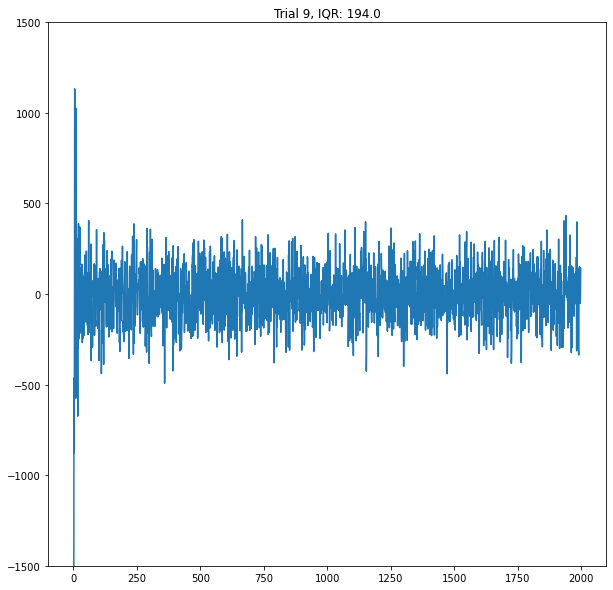

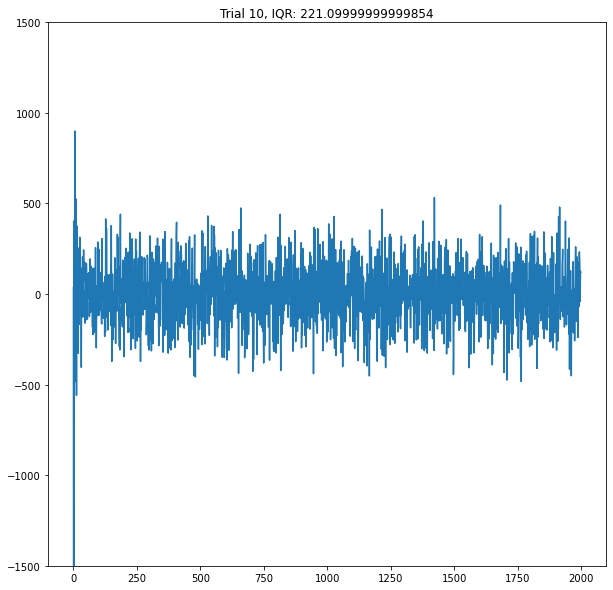

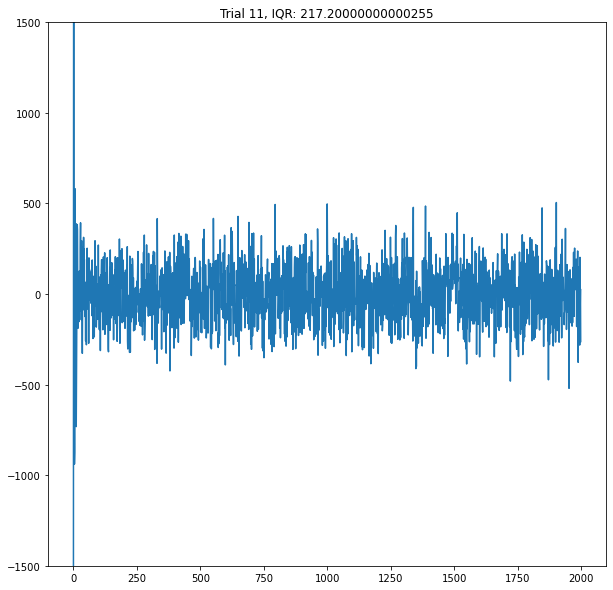

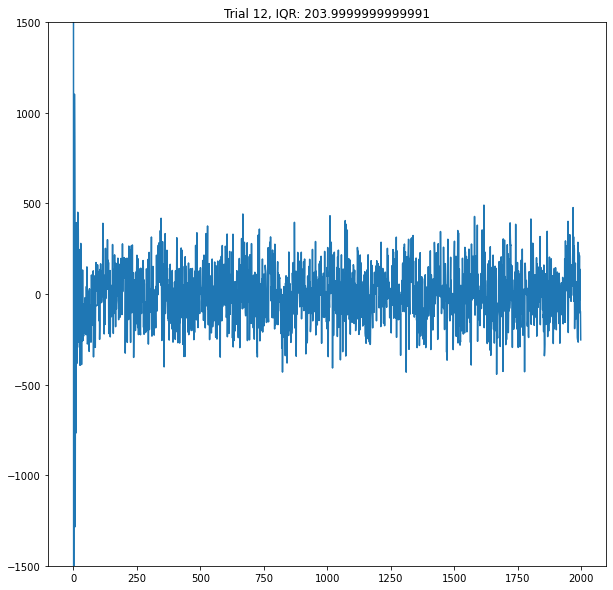

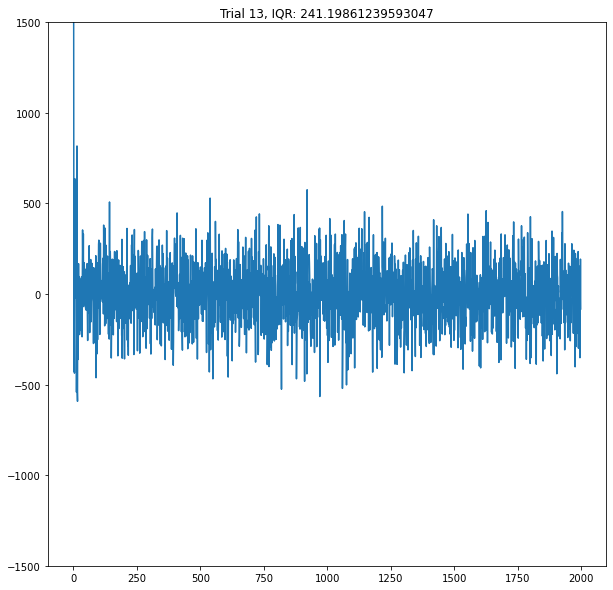

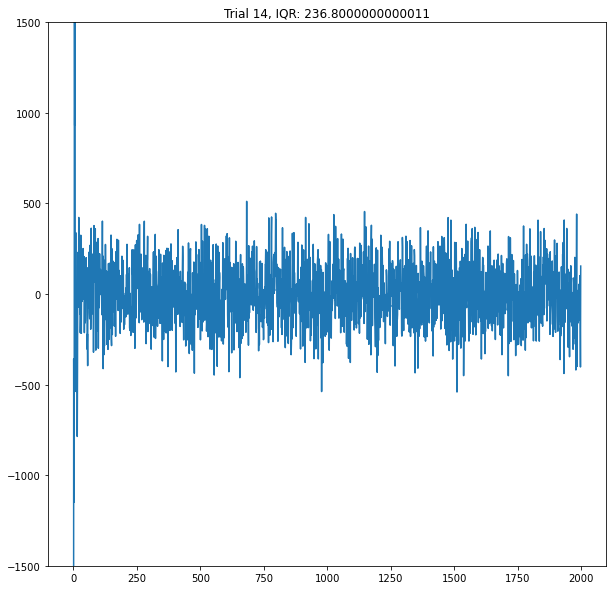

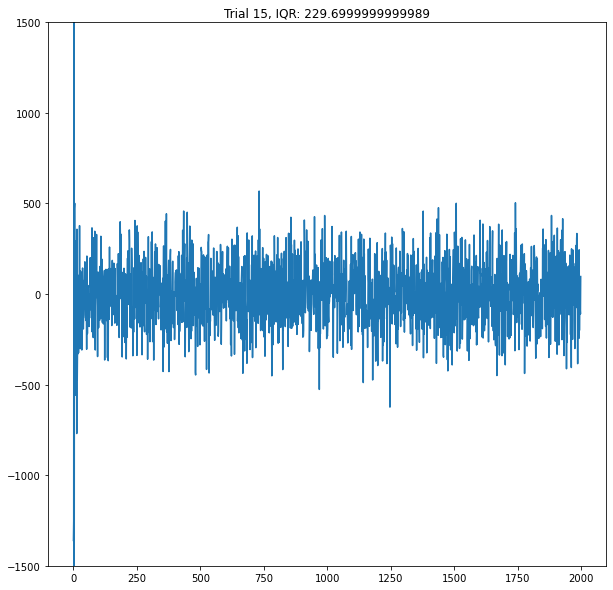

In [7]:
for i in range(16):
    arr = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(arr)
    moving_ave = df.iloc[1:,1].rolling(50,min_periods=1).mean().values.flatten().tolist()
    diff = differencing(moving_ave,1)
    IQR_val = IQR(diff)
    print(f"Detrended Trial {i} IQR: {IQR_val}")
    x = np.array([i for i in range(len(diff))])
    fig = plt.figure(figsize = (10,10))
    plt.ylim((-1.5e3,1.5e3))
    plt.title(f"Trial {i}, IQR: {IQR_val}")
    plt.plot(x,diff)

In [40]:
df_collate_detrend = pd.DataFrame([])
print("Run 1: During Learning Detrended Standard Deviations")
for i in range(len(params_array)):
    arr = params_array[i]
    
    arr_r = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(arr_r)
    moving_ave = df.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    diff = differencing(moving_ave,1)
    
    df_interest = pd.DataFrame(diff)
    df_collate_detrend = pd.concat([df_collate_detrend, df_interest], axis=1)
    
    print(f"Treatment {i}: Variance = {np.std(diff)}")


Run 1: During Learning Detrended Standard Deviations
Treatment 0: Variance = 40.76250496787362
Treatment 1: Variance = 43.237581271589804
Treatment 2: Variance = 59.156271354764336
Treatment 3: Variance = 78.26900369298465
Treatment 4: Variance = 75.829128462654
Treatment 5: Variance = 63.338954667529215
Treatment 6: Variance = 82.35446716271397
Treatment 7: Variance = 135.5712305693744
Treatment 8: Variance = 83.71787677438826
Treatment 9: Variance = 87.82034729035642
Treatment 10: Variance = 123.43698702315798
Treatment 11: Variance = 163.48132214488024
Treatment 12: Variance = 62.58499371740047
Treatment 13: Variance = 87.87941730975922
Treatment 14: Variance = 143.52238290444365
Treatment 15: Variance = 191.99657110081148


# Visualise All Plots

In [5]:
params = {'max_kl' : [1e-06,1e-05,1e-04,1e-03],
          'gamma' : [0.8,0.9,0.95,0.99]}

X1 = [0,1,2,3]
X2 = [0,1,2,3]
full_fact = []

for combination in itertools.product(X1,X2):
    full_fact.append(combination)
print(full_fact)

params_array = [(params['max_kl'][x[0]],params['gamma'][x[1]]) for x in full_fact]
print(params_array)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
[(1e-06, 0.8), (1e-06, 0.9), (1e-06, 0.95), (1e-06, 0.99), (1e-05, 0.8), (1e-05, 0.9), (1e-05, 0.95), (1e-05, 0.99), (0.0001, 0.8), (0.0001, 0.9), (0.0001, 0.95), (0.0001, 0.99), (0.001, 0.8), (0.001, 0.9), (0.001, 0.95), (0.001, 0.99)]


In [10]:
params_df = pd.DataFrame(params_array,columns=['max_kl','gamma'])

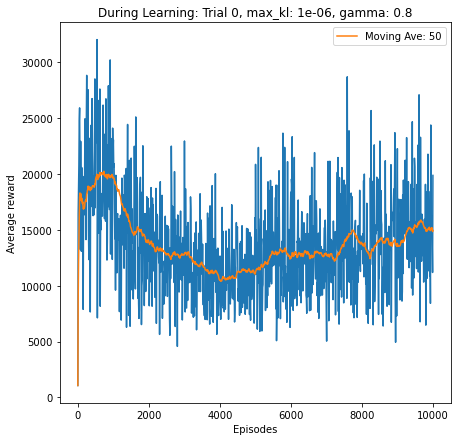

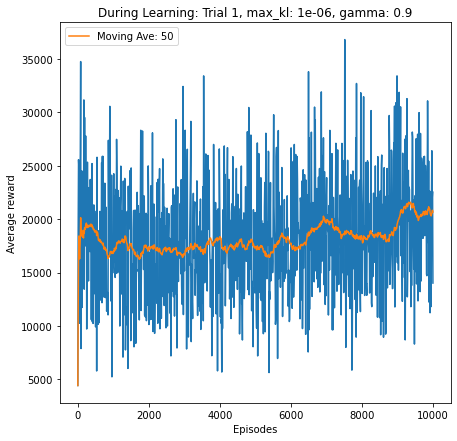

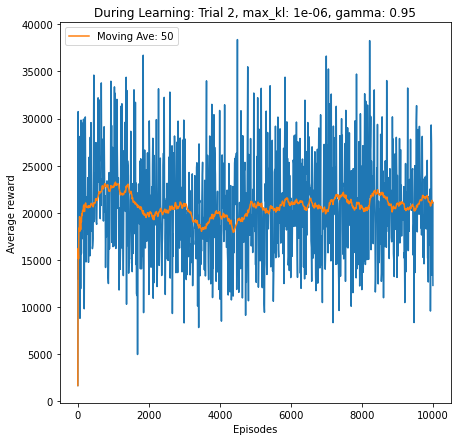

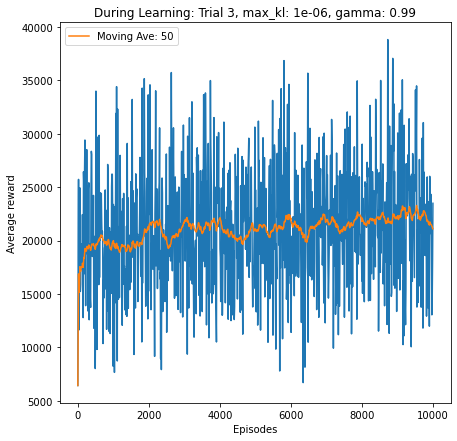

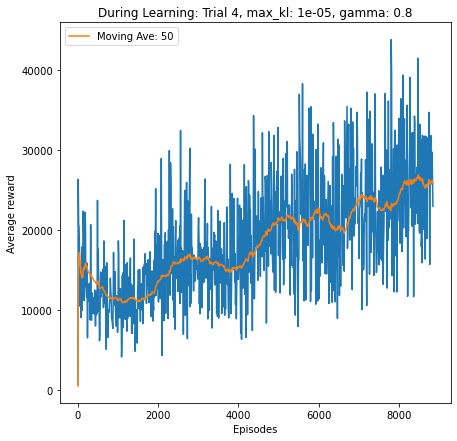

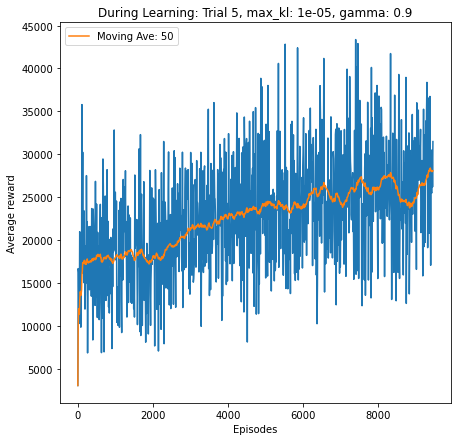

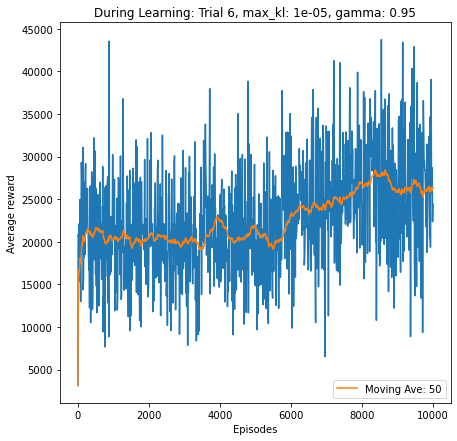

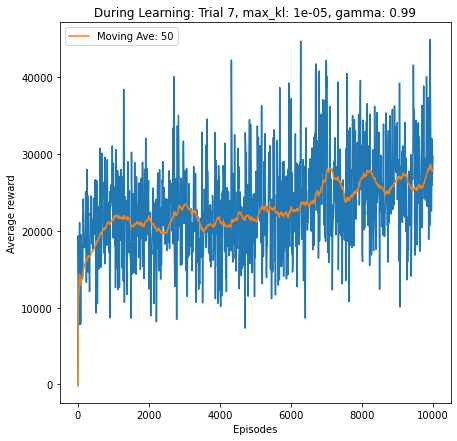

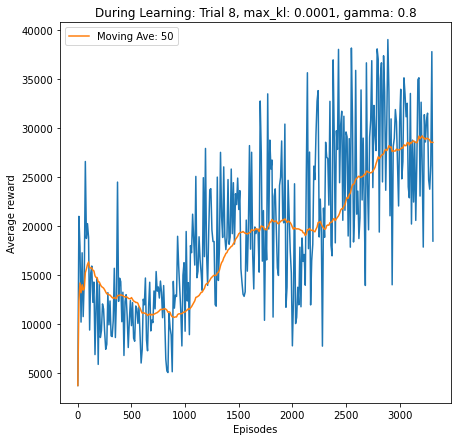

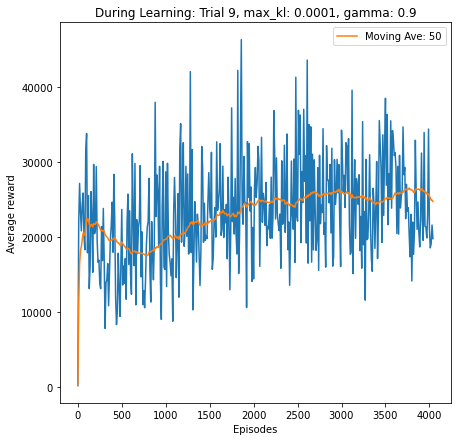

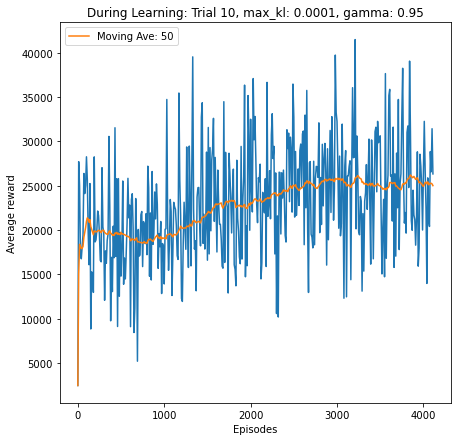

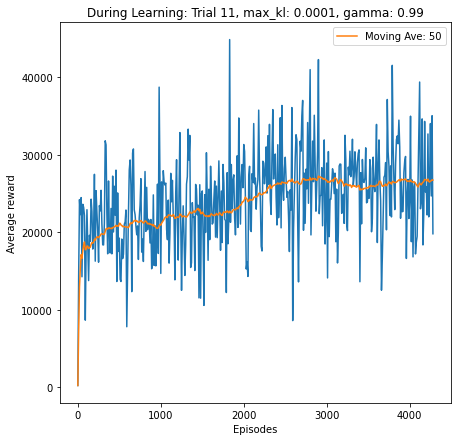

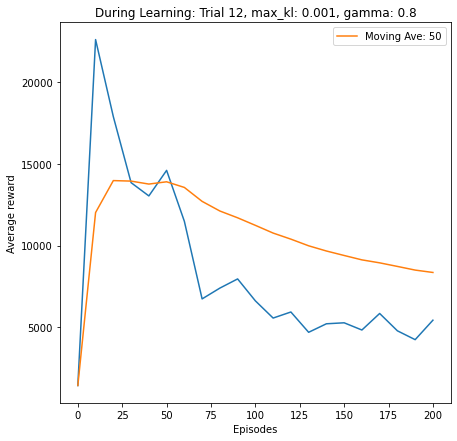

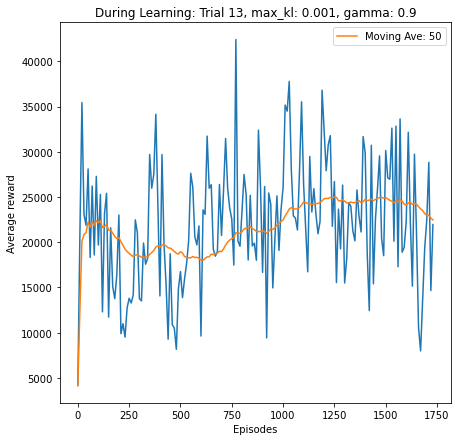

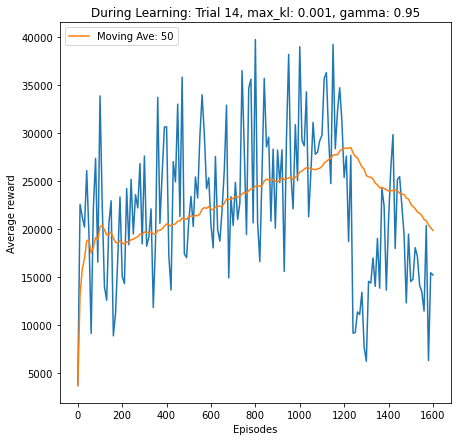

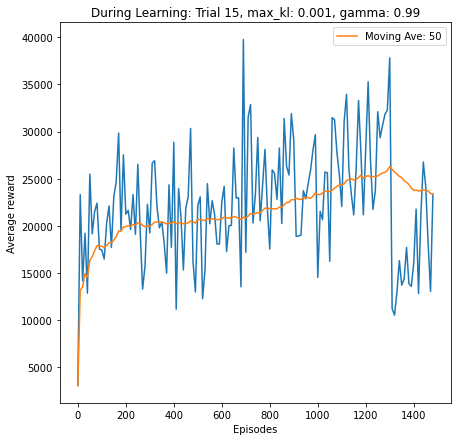

In [5]:
for i in range(len(params_array)):
    arr = params_array[i]
    fig = plt.figure(figsize=(7,7))
    plt.title(f"During Learning: Trial {i}, max_kl: {arr[0]}, gamma: {arr[1]}")
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    moving_ave = df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    
    #data_eval = np.loadtxt(f"run_1/eval_trial_{i}.txt",delimiter=",")
#     df_eval = pd.DataFrame(data_eval)
#     eval_moving_ave = df_eval.iloc[1:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()
    
    plt.plot(data[:,1],data[:,0])
    plt.plot(data[:,1],moving_ave,label = "Moving Ave: 50")
    #plt.plot(data_eval[1:,1],eval_moving_ave,label="Eval Moving Ave: 50")
    plt.legend()
    plt.xlabel('Episodes')
    plt.ylabel('Average reward')

# BoxPlot

In [18]:
df_collate = pd.DataFrame([])
for i in range(len(params_array)):
    arr = params_array[i]
    #fig = plt.figure(figsize=(10,10))
    #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    
    df = pd.DataFrame(data)
    df_interest = df.iloc[:,0]
    df_collate = pd.concat([df_collate, df_interest], axis=1)
    

In [19]:
df_collate.columns = [f"Trial {x}" for x in range(16)]

In [20]:
df_collate = df_collate.drop(0)
df_collate

Trial 0  Trial 1  Trial 2  Trial 3  Trial 4  Trial 5  Trial 6  Trial 7  \
1    16410.0  18820.0  30740.0  18470.0  26330.0  16670.0  20790.0  19340.0   
2    18510.0  25560.0  12950.0  25730.0  20550.0  16220.0  20670.0  15340.0   
3    20790.0  24880.0  28110.0  11620.0  20500.0  10260.0  22090.0  12850.0   
4    24750.0  13730.0  17920.0  13480.0  17890.0  10610.0  15360.0  17480.0   
5    25900.0  10240.0  26160.0  22240.0  12060.0  20970.0  19690.0  21080.0   
..       ...      ...      ...      ...      ...      ...      ...      ...   
995  15580.0  22280.0  27330.0  19420.0      NaN      NaN  25880.0  22580.0   
996  16260.0  26400.0  16910.0  13040.0      NaN      NaN  28390.0  32030.0   
997  13480.0  21960.0  13370.0  14550.0      NaN      NaN  28680.0  25950.0   
998  11180.0  22580.0  21170.0  18210.0      NaN      NaN  22350.0  27980.0   
999  19860.0  14010.0  12300.0  23490.0      NaN      NaN  24430.0  29750.0   

     Trial 8  Trial 9  Trial 10  Trial 11  Trial 12  Trial 13  Trial 14  \
1    21000.0  21990.0   27720.0   14370.0   22580.0   20770.0   22560.0   
2    17870.0  27190.0   24990.0   24200.0   17870.0   35430.0   21240.0   
3    10230.0  23480.0   17650.0   22270.0   13840.0   23050.0   20190.0   
4    17290.0  20870.0   16760.0   24460.0   13030.0   21870.0   26060.0   
5    10790.0  24340.0   18080.0   14260.0   14590.0   28090.0   19550.0   
..       ...      ...       ...       ...       ...       ...       ...   
995      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
996      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
997      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
998      NaN      NaN       NaN       NaN       NaN       NaN       NaN   
999      NaN      NaN       NaN       NaN       NaN       NaN       NaN   

     Trial 15  
1     23300.0  
2     14130.0  
3     19190.0  
4     12830.0  
5     25480.0  
..        ...  
995       NaN  
996       NaN  
997       NaN  
998       NaN  
999       NaN  

[999 rows x 16 columns]

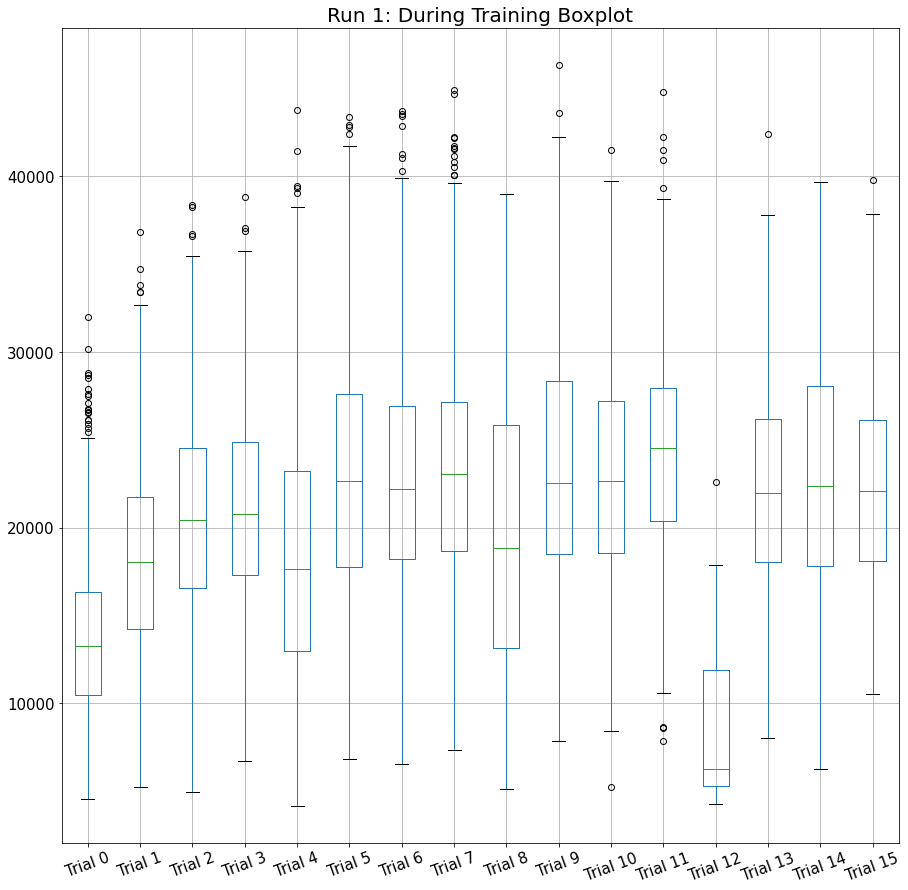

In [21]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: During Training Boxplot",fontsize = 20)
ax = df_collate.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

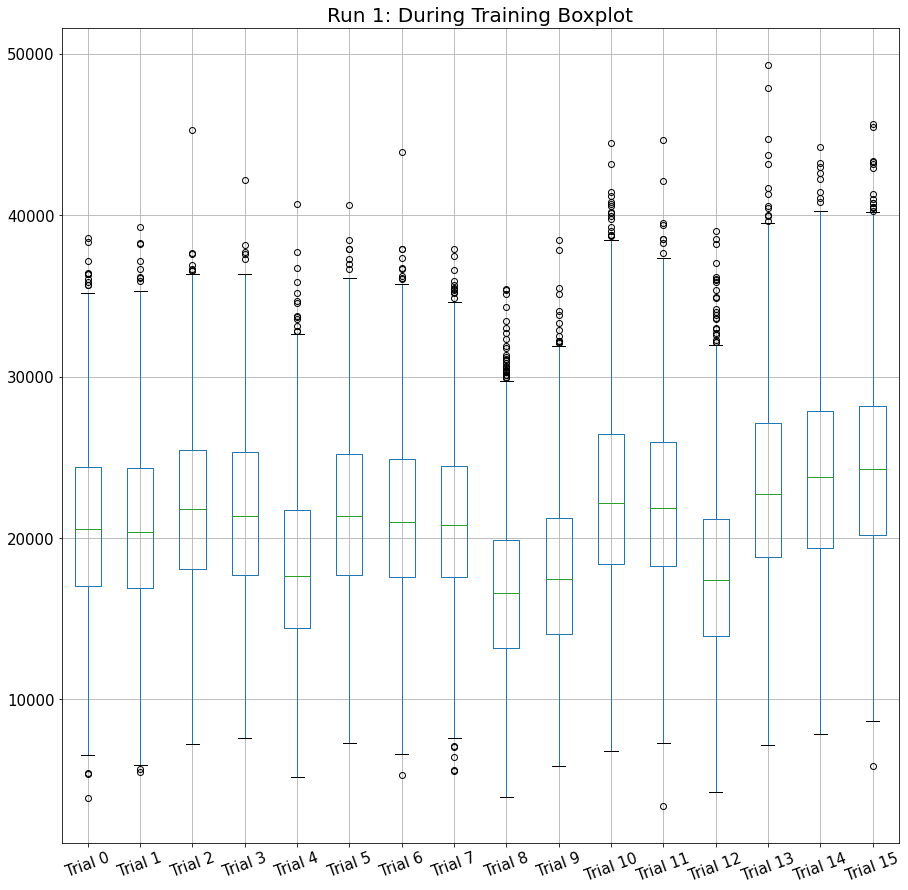

In [20]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: During Training Boxplot",fontsize = 20)
ax = df_collate.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

# Mean & Standard Dev

During Learning

In [87]:
variance_weight = 1
for i in range(len(params_array)):
    arr = params_array[i]
    
    data = np.loadtxt(f"run_1/trial_{i}.txt",delimiter = ',')
    df = pd.DataFrame(data)
    moving_ave = np.array(df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten())
    Mean = round(np.mean(moving_ave),2)
    Std = round(np.std(moving_ave),2)
    iqr = round(IQR(moving_ave),2)
    Mean_last_n = np.mean(df.iloc[-100:,0])
    
    print(f"Total Trial {i}, Mean: {Mean}, Std Dev: {Std}, Mean last 100: {Mean_last_n} SNR: {Mean/(variance_weight*Std)}, IQR: {iqr}")
#     for j in range(3):
#         Mean_third = round(np.mean(moving_ave[1000*j:1000*(j+1)]),2)
#         Std_third = round(np.std(moving_ave[1000*j:1000*(j+1)]),2)
#         iqr_third = round(IQR(moving_ave[1000*j:1000*(j+1)]),2)
#         print(f"Quatile {j+1} Trial {i}, Mean: {Mean_third}, Std Dev: {Std_third}, SNR: {Mean_third/(variance_weight*Std_third)}, IQR: {iqr_third}")
    
    print()

Total Trial 0, Mean: 7214.22, Std Dev: 1141.7, Mean last 100: 8594.8 SNR: 6.318840325829902, IQR: 2234.85

Total Trial 1, Mean: 7390.71, Std Dev: 1534.01, Mean last 100: 9012.15 SNR: 4.817902099725556, IQR: 2933.3

Total Trial 2, Mean: 8849.28, Std Dev: 1991.33, Mean last 100: 11675.9 SNR: 4.443904325249959, IQR: 4143.45

Total Trial 3, Mean: 7449.68, Std Dev: 2107.4, Mean last 100: 13471.2 SNR: 3.5350099648856412, IQR: 2542.9

Total Trial 4, Mean: 8728.37, Std Dev: 1043.72, Mean last 100: 8919.95 SNR: 8.362750546123483, IQR: 1007.15

Total Trial 5, Mean: 8342.25, Std Dev: 1150.83, Mean last 100: 8861.2 SNR: 7.248898620995282, IQR: 629.8

Total Trial 6, Mean: 9936.32, Std Dev: 2282.7, Mean last 100: 12592.75 SNR: 4.352880360976037, IQR: 2314.65

Total Trial 7, Mean: 16127.48, Std Dev: 5809.93, Mean last 100: 19165.35 SNR: 2.7758475575437225, IQR: 6018.5

Total Trial 8, Mean: 9301.67, Std Dev: 981.56, Mean last 100: 9934.9 SNR: 9.476415094339623, IQR: 860.5

Total Trial 9, Mean: 10960.8

# After Learning Evaluation

In [6]:
from machine import Machine
from GymMachEnv import MachineEnv

In [7]:
def compute_avg_return(environment, policy, num_episodes):
    total_return = 0.0
    for _ in range(num_episodes):
        state = torch.Tensor(environment.reset())
        state = state.unsqueeze(0)
        episode_return = 0.0 
        while not environment.done:
            action = policy(state).sample()
            next_state, reward, done, _ = environment.step(action)
            next_state = torch.Tensor(next_state)
            next_state = next_state.unsqueeze(0)
            state = next_state
            episode_return += reward
        total_return += episode_return   
    avg_return = total_return / num_episodes
    return avg_return# Evaluate the agent's policy once before training.

In [8]:
def evaluate(env,agent):
    episodic_rewards = []
    trials = 500
    
    
    for t in range(trials):
        episodic_rewards.append(compute_avg_return(env,agent,20))
        #print(episodic_rewards[-1])
        
    return np.array(episodic_rewards)


In [25]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

runs = ['eval_1','eval_2','eval_3']


for x in runs:
    for i in range(16):
        model = torch.load(f'run_1/trial_{i}_TRPO_agent.pt')
        model.eval()
        parameters = params_array[i]
        result = evaluate(env,model)
        np.savetxt(f'run_1/{x}/evaluated_trial_{i}.txt', result, delimiter=',',fmt='%s')
    

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


# Processing

In [7]:
runs = ['eval_1','eval_2','eval_3']
df_total = pd.DataFrame()

for x in runs:
    mean_arr = []
    for i in range(16):
        mean_arr.append(np.mean(np.loadtxt(f'run_1/{x}/evaluated_trial_{i}.txt')))
    df= pd.DataFrame(mean_arr)
    df_total= pd.concat([df_total,df],axis=1)

# df_total.columns = runs
# df_total['average'] = df_total.mean(axis=1)
# df_total = pd.concat([params_df,df_total],axis=1)
# df_total.to_csv('TRPO_results.csv')


# Visualisation of After Learning

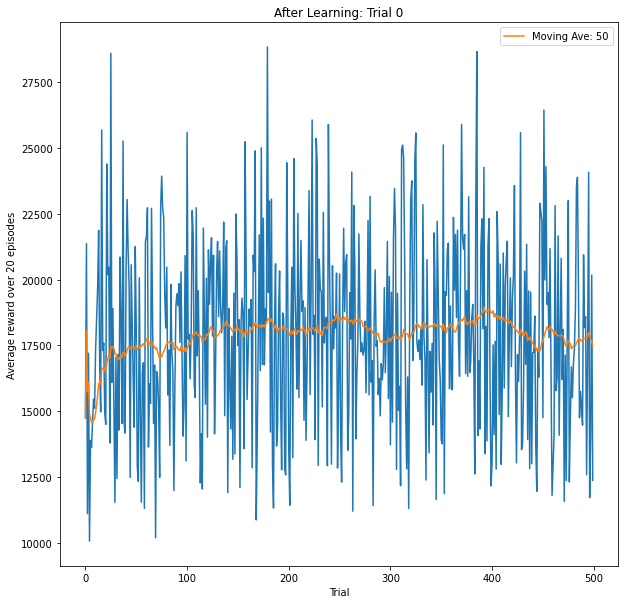

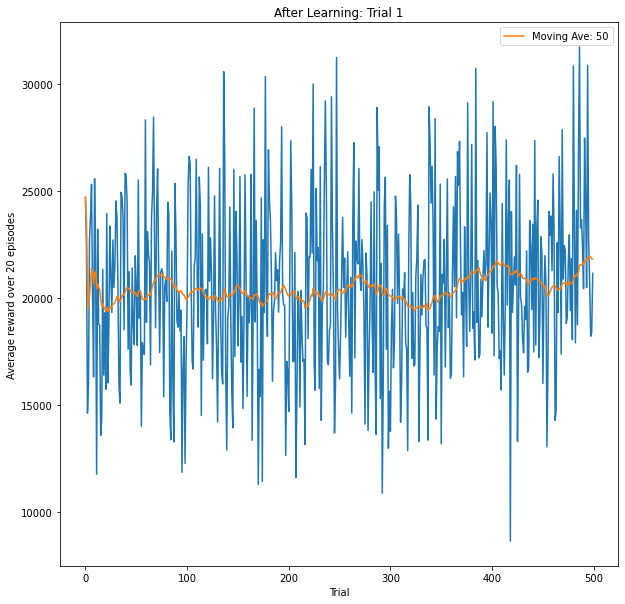

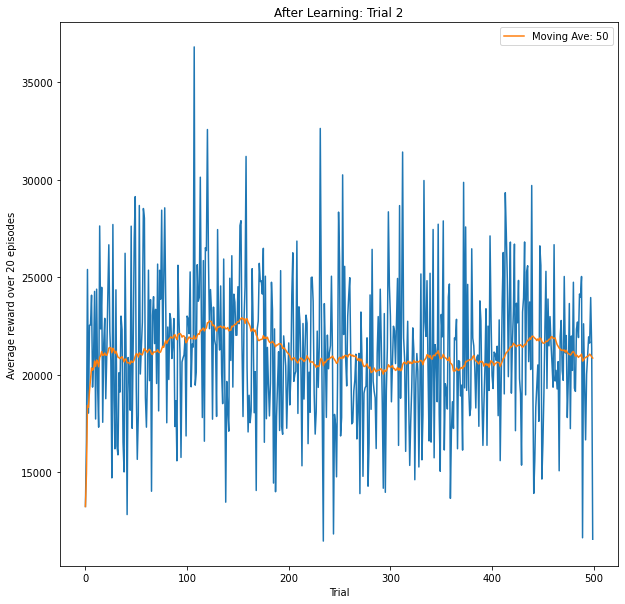

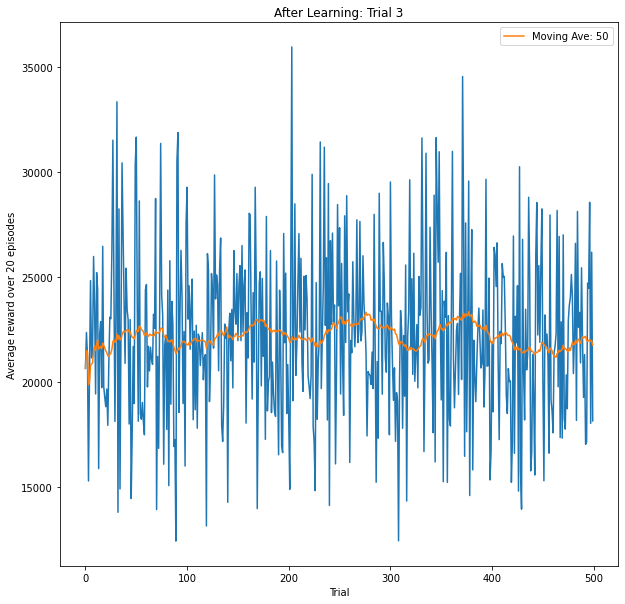

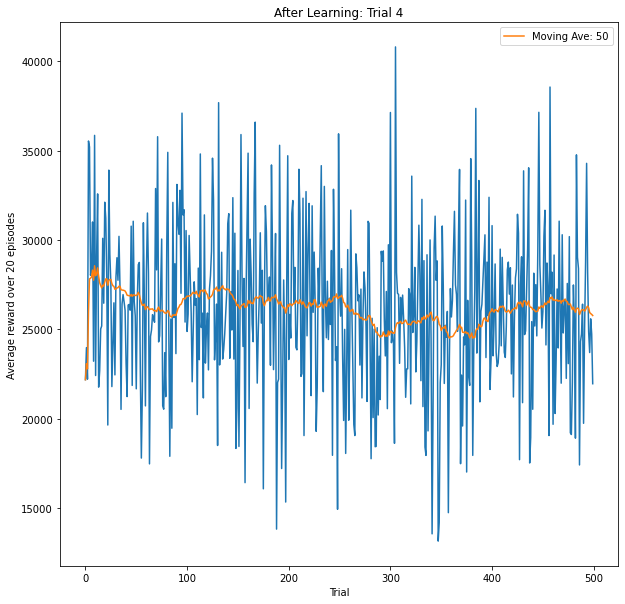

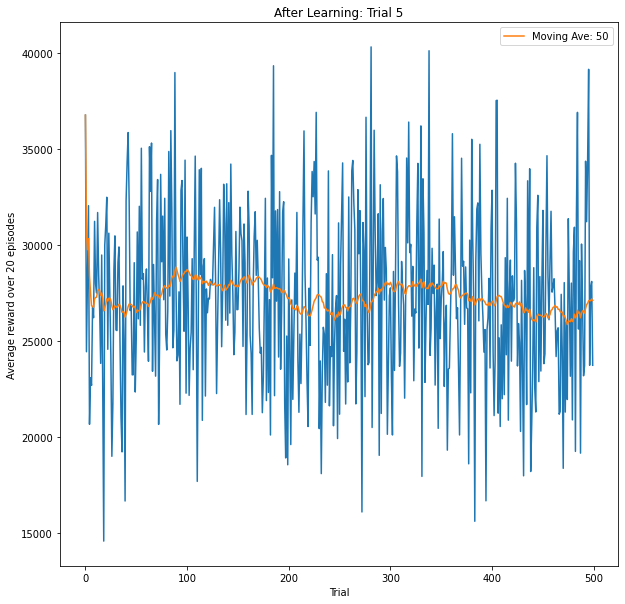

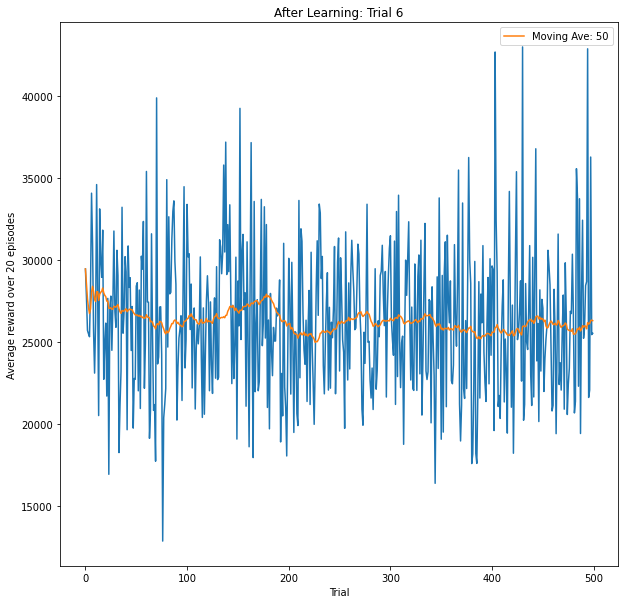

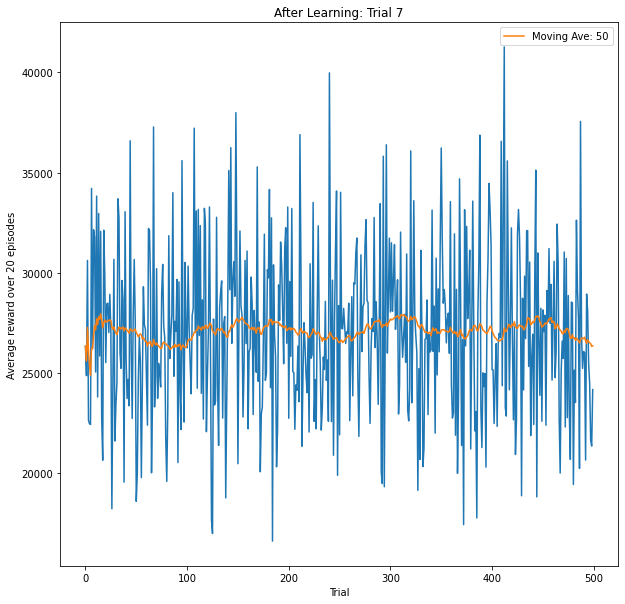

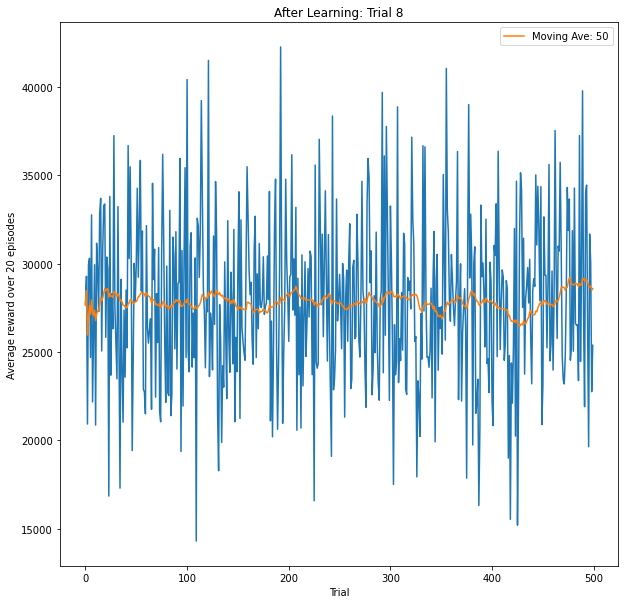

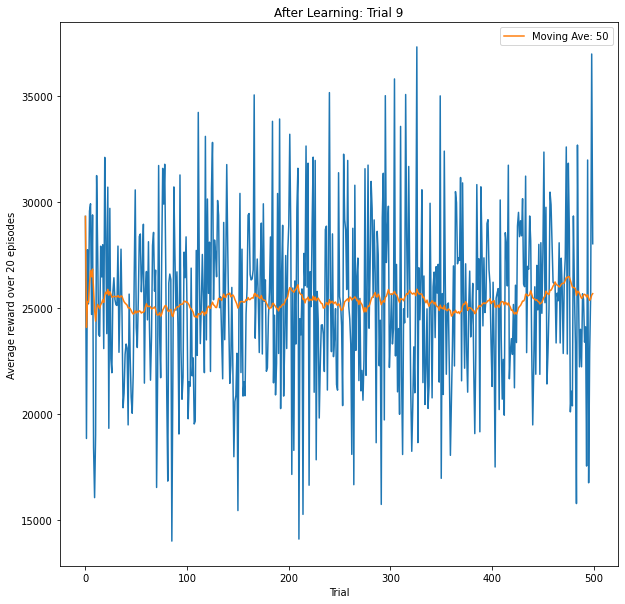

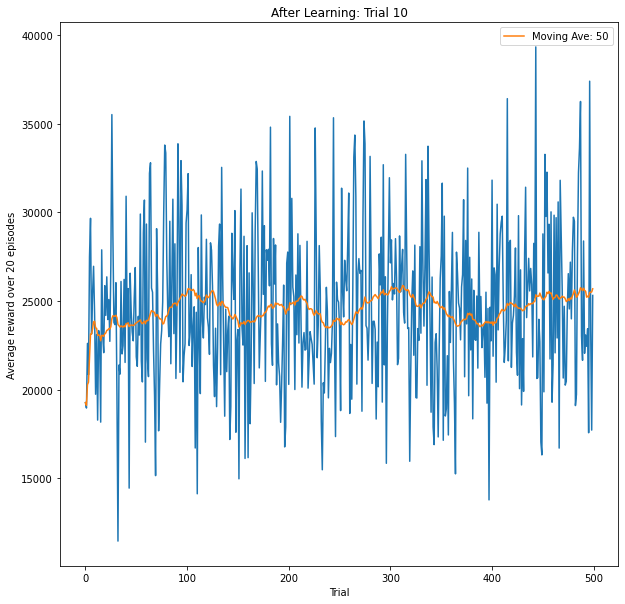

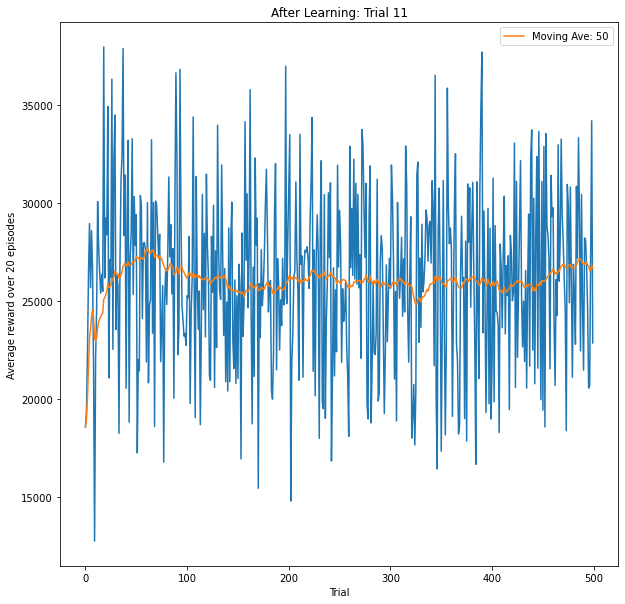

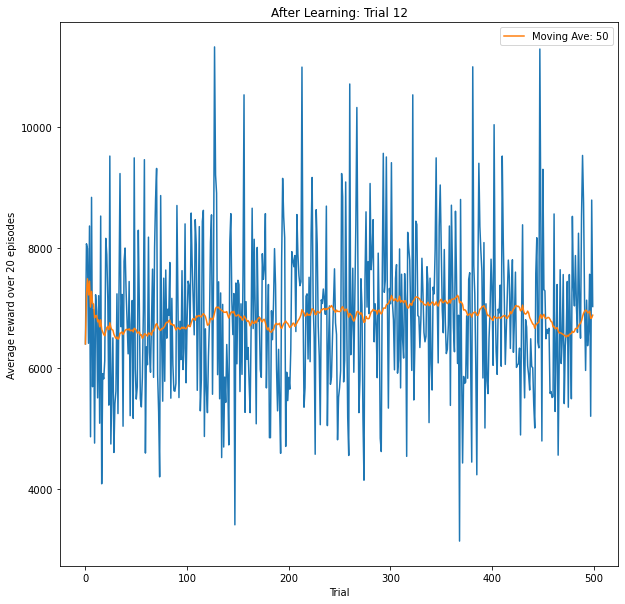

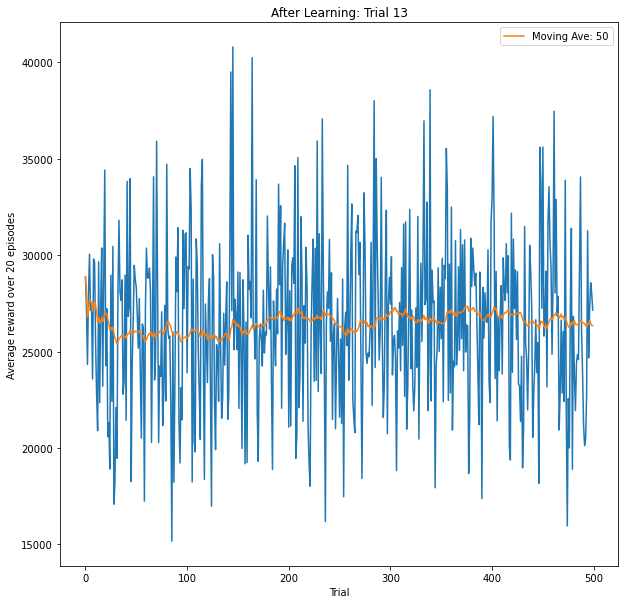

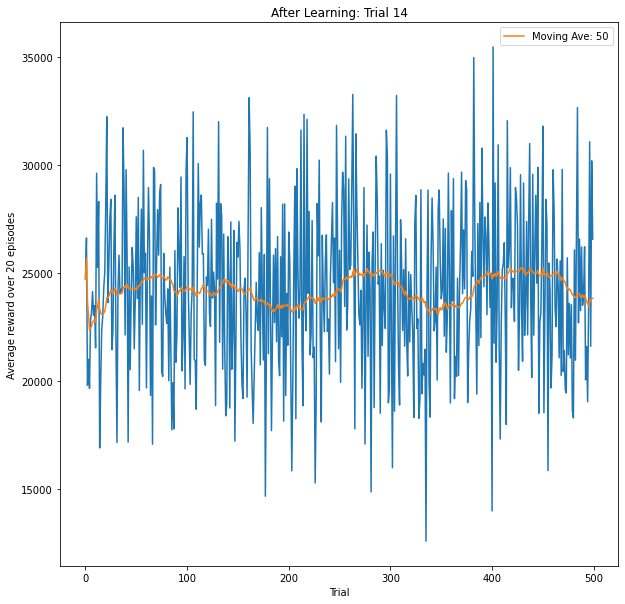

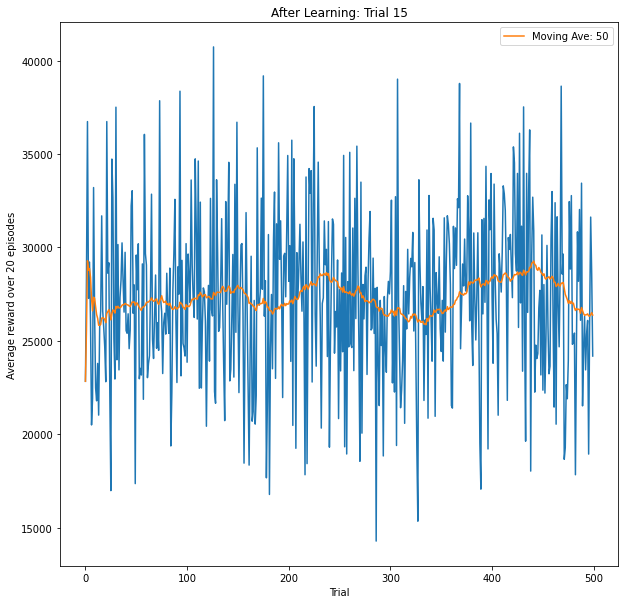

In [23]:
for i in range(len(params_array)):
    arr = params_array[i]
    
    data = np.loadtxt(f"run_1/eval_2/evaluated_trial_{i}.txt")
    df = pd.DataFrame(data)
    ep = [x for x in range(len(data))]
    moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
    
    fig = plt.figure(figsize=(10,10))
    plt.title(f"After Learning: Trial {i}")
    plt.plot(ep,data)
    plt.plot(ep,moving_ave,label = "Moving Ave: 50")
    plt.legend()
    plt.xlabel('Trial')
    plt.ylabel('Average reward over 20 episodes')
    plt.show()

<Figure size 720x720 with 0 Axes>

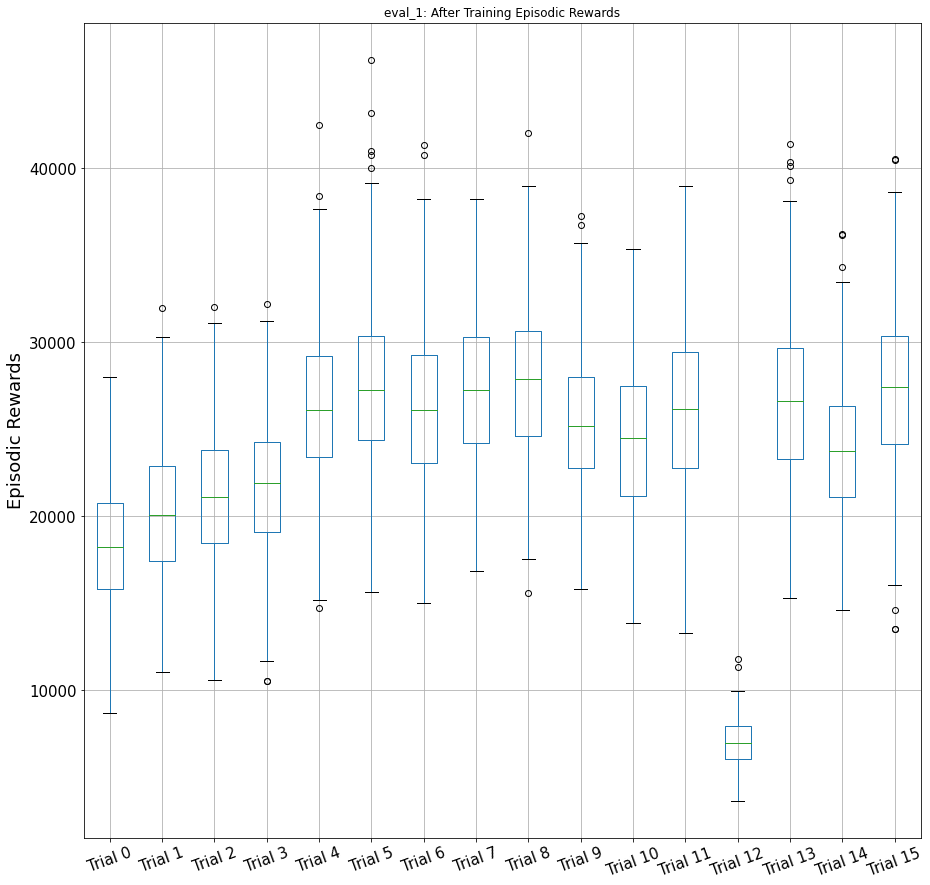

<Figure size 720x720 with 0 Axes>

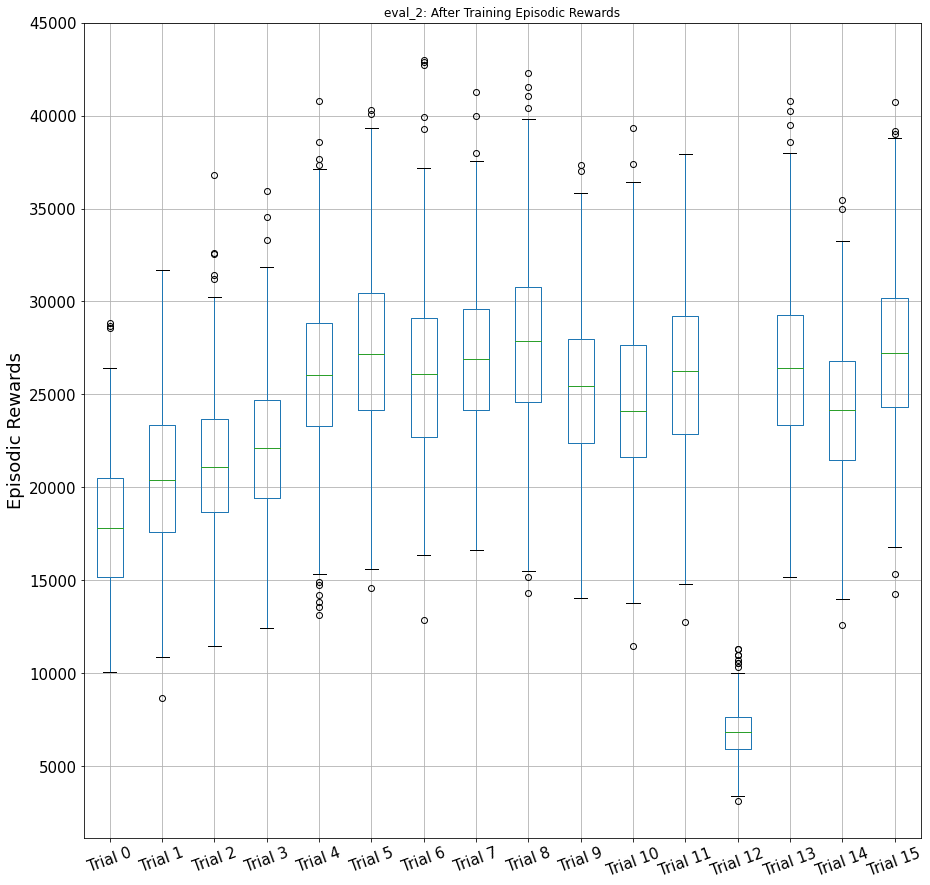

<Figure size 720x720 with 0 Axes>

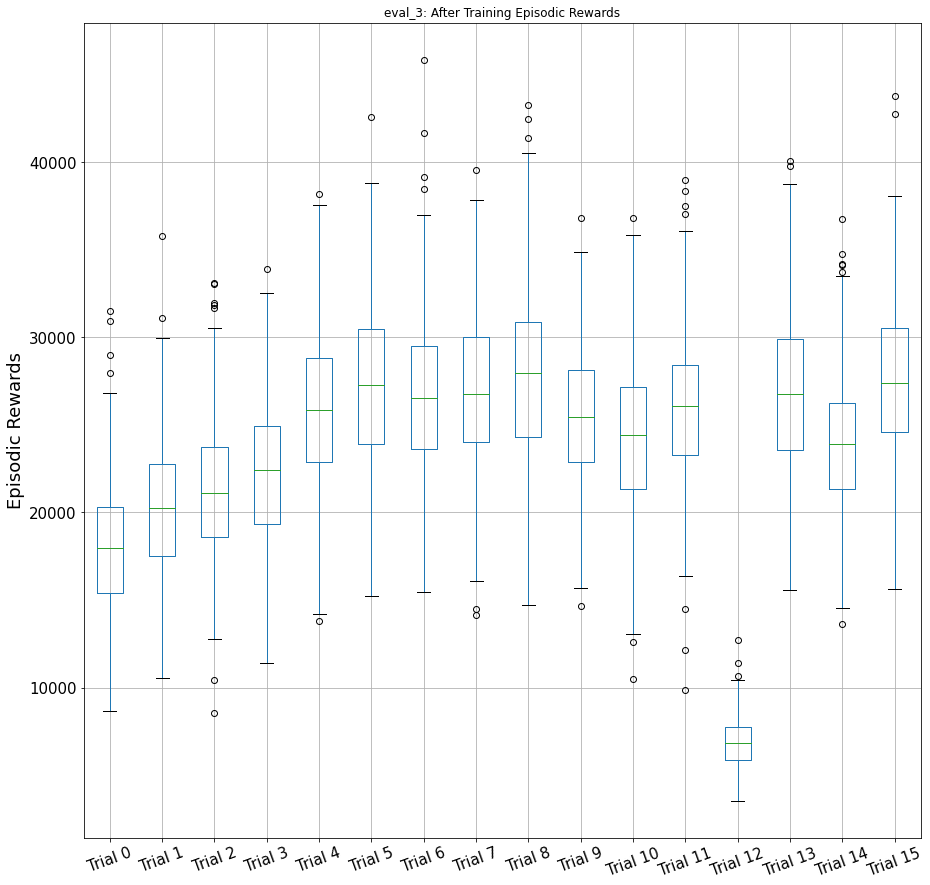

In [8]:
for x in runs:
    df_collate_all = pd.DataFrame([])
    fig = plt.figure(figsize=(10,10))
    for i in range(len(params_array)):
        arr = params_array[i]
        #fig = plt.figure(figsize=(10,10))
        #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
        data = np.loadtxt(f"run_1/{x}/evaluated_trial_{i}.txt")
        df = pd.DataFrame(data)
        df_collate_all = pd.concat([df_collate_all, df], axis=1)
    
    
    df_collate_all.columns = [f"Trial {x}" for x in range(16)]
    fig = plt.figure(figsize=(15,15))
    plt.title("Run 1: During Training Boxplot",fontsize = 20)
    ax = df_collate_all.boxplot(grid=True, rot=20, fontsize=15)
    plt.title(f'{x}: After Training Episodic Rewards')
    plt.ylabel('Episodic Rewards',fontsize=18)
    plt.show()

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

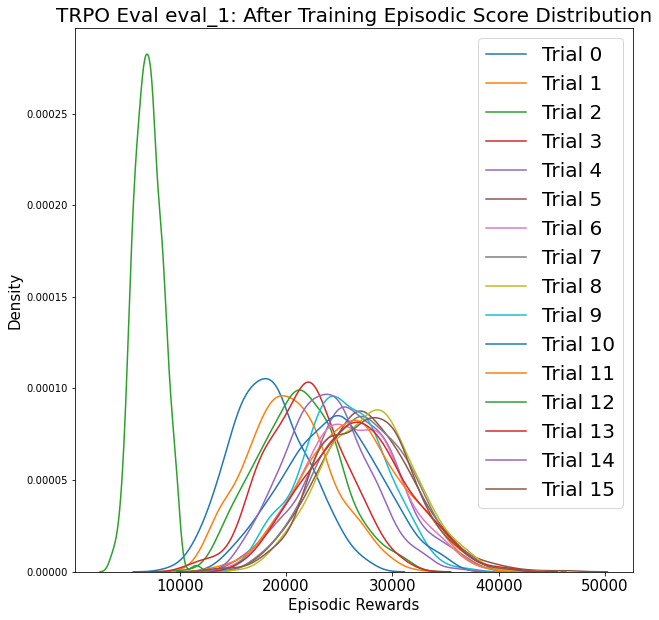

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

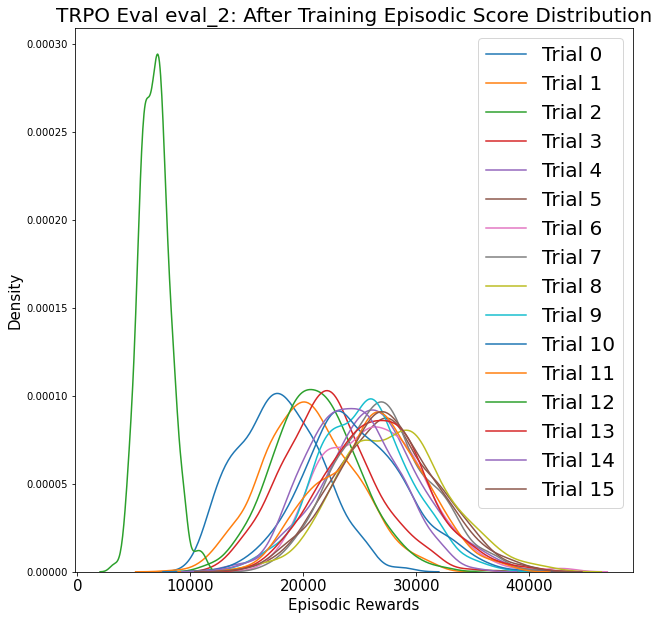

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

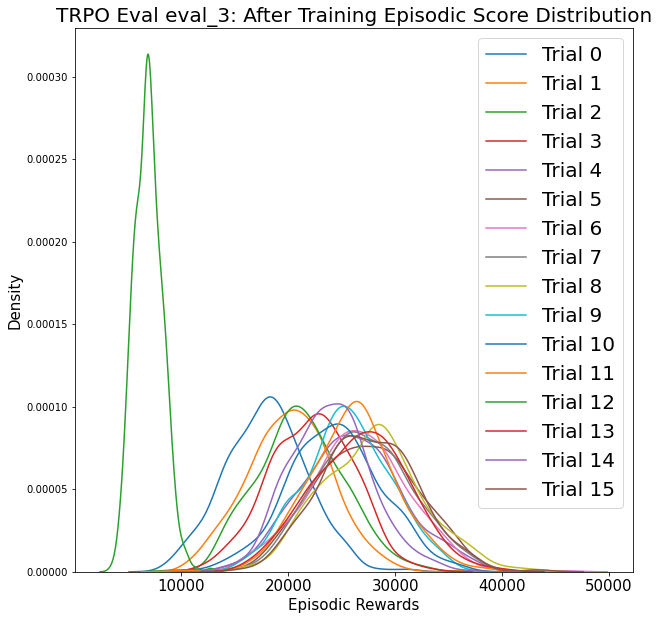

In [35]:
import seaborn as sns
runs = ['eval_1','eval_2','eval_3']

for x in runs:
    fig = plt.figure(figsize=(10,10))
    for i in range(len(params_array)):
        arr = params_array[i]
        #fig = plt.figure(figsize=(10,10))
        #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
        data = np.loadtxt(f"run_1/{x}/evaluated_trial_{i}.txt")

        df_interest = pd.DataFrame(data)
        #print(df_interest.head())
        ax = sns.distplot(df_interest,hist=False,label=f"Trial {i}")
    plt.legend(prop={'size': 20})
    plt.title(f"TRPO Eval {x}: After Training Episodic Score Distribution",fontsize=20)
    plt.xlabel("Episodic Rewards",fontsize=15)
    plt.ylabel("Density",fontsize=15)
    plt.xticks(fontsize= 15)
    plt.show()

Moving Average

In [ ]:
runs = ['eval_1','eval_2','eval_3']
weight_var = 1
for eval in runs:
    print(eval)
    for i in range(len(params_array)):
        arr = params_array[i]
        data = np.loadtxt(f"run_1/{eval}/evaluated_trial_{i}.txt")
        df = pd.DataFrame(data)
        moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
        mean = np.mean(moving_ave)
        std = np.std(moving_ave)
        median = np.median(moving_ave)
        IQR_ = IQR(moving_ave)
        if mean < 10000: continue
        print(f"Trial {i}, Mean: {round(mean,2)}, Std: {round(std,2)}, SNR: {round(mean/(weight_var*std),2)}, Median: {round(median,2)}, IQR: {round(IQR_,2)}, Median/IQR: {round(median/(weight_var*IQR_),2)}")
    print()

In [27]:
df_collate_fp = pd.DataFrame([])
for i in range(len(params_array)):
    arr = params_array[i]
    #fig = plt.figure(figsize=(10,10))
    #plt.title(f"Trial {i}, Learning rate: {arr[0]}, Gamma: {arr[1]}, Eps Decay: {arr[2]}, Update Freq: {arr[3]}")
    data = np.loadtxt(f"run_1/eval_1/evaluated_trial_{i}.txt")
    
    df_interest = pd.DataFrame(data)
    df_collate_fp = pd.concat([df_collate_fp, df_interest], axis=1)

In [30]:
df_collate_fp.columns = [f"Trial {x}" for x in range(16)]


In [ ]:
fig = plt.figure(figsize=(15,15))
plt.title("Run 1: After Training Boxplot",fontsize = 20)
ax = df_collate_fp.boxplot(grid=True, rot=20, fontsize=15)
plt.show()

# Best

In [34]:
machine = Machine()
machine.curr_state = 0
env = MachineEnv(machine)

model = torch.load('default/trial_0_TRPO_agent.pt')
model.eval()

arr = evaluate(env,model)
np.savetxt(f'default/evaluated_trial_0.txt', arr, delimiter=',',fmt='%s')

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.20.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


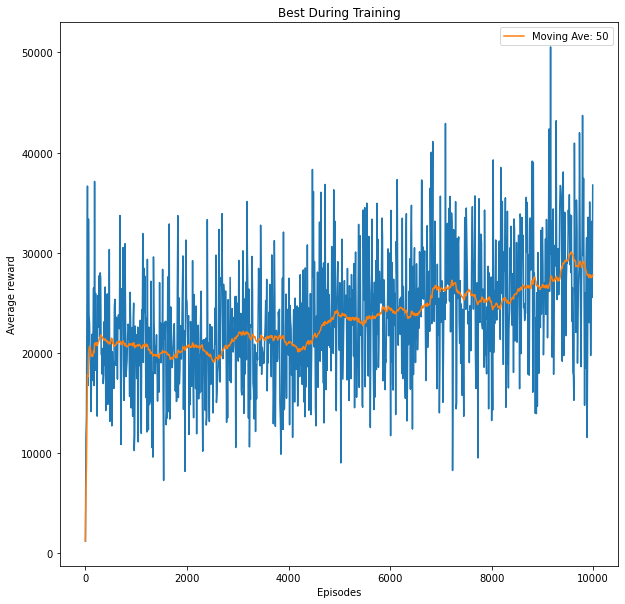

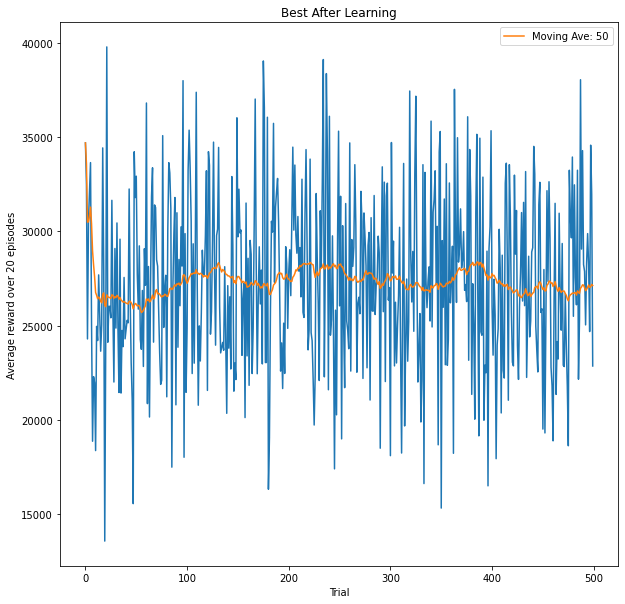

C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\overl\anaconda3\envs\env1\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


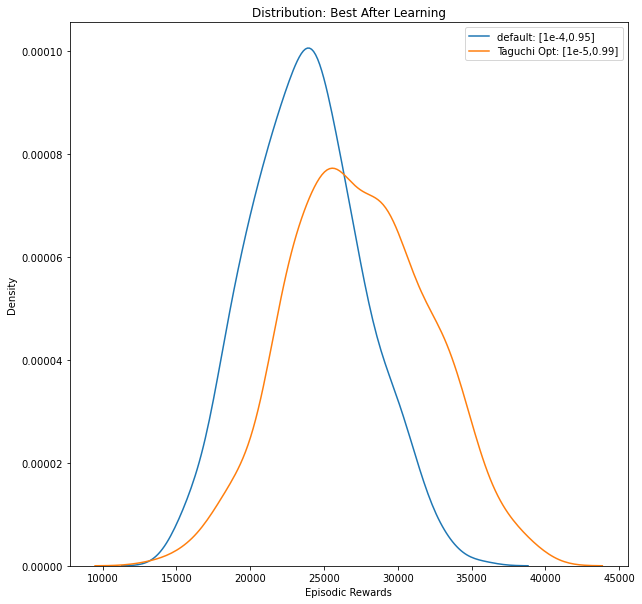

In [39]:
data = np.array(pd.read_csv('best/trial_0.txt',header=None))

df = pd.read_csv('best/trial_0.txt',header=None)
moving_ave = df.iloc[:,0].rolling(50,min_periods=1).mean().values.flatten().tolist()

fig = plt.figure(figsize=(10,10))
plt.plot(data[:,1],data[:,0])
plt.plot(data[:,1],moving_ave,label = "Moving Ave: 50")
#plt.plot(data_eval[1:,1],eval_moving_ave,label="Eval Moving Ave: 50")
plt.title('Best During Training')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Average reward')
plt.show()



data = np.loadtxt(f"best/evaluated_trial_0.txt")
df = pd.DataFrame(data)
ep = [x for x in range(len(data))]
moving_ave = np.array(df.rolling(50,min_periods=1).mean().values.flatten())
fig = plt.figure(figsize=(10,10))
plt.title(f"Best After Learning")
plt.plot(ep,data)
plt.plot(ep,moving_ave,label = "Moving Ave: 50")
plt.legend()
plt.xlabel('Trial')
plt.ylabel('Average reward over 20 episodes')
plt.show()

fig = plt.figure(figsize=(10,10))
plt.title(f"Distribution: Best After Learning")
data = np.loadtxt("default/evaluated_trial_0.txt")
df_default = pd.DataFrame(data)
ax = sns.distplot(df_default,hist=False,label=f"default: [1e-4,0.95] ")
ax = sns.distplot(df,hist=False,label=f"Taguchi Opt: [1e-5,0.99]")
plt.legend()
plt.xlabel('Episodic Rewards')
plt.show()